# Predictive Modeling for Italian Rental Prices

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

#set style
plt.style.use('seaborn-v0_8')
sns.set_theme(style = 'whitegrid')
pd.set_option('display.max_columns', None)


In [4]:
# Load the cleaned data
df = pd.read_csv('data/italian_rental_processed.csv')

In [5]:
df.head()

,date_posted,year,month,season,city,neighborhood,region,price,price_per_m2,area,bathrooms,floor,total_floors,parking_spaces,num_bedrooms,num_living_rooms,total_rooms,energy_value,energy_class,room_to_bathroom_ratio,floor_to_height_ratio,bedroom_ratio,has_elevator,has_furnished,has_balcony,has_tv_system,has_external_exposure,has_fiber_optic,has_electric_gate,has_cellar,has_shared_garden,has_private_garden,has_doorman,has_pool,is_villa,is_apartment,is_penthouse,is_loft,is_mansard
0,2023-03-07,2023,3,2,Milano,Centrale,lombardia,1800.0,30.000000,60.0,1.0,9.0,10.0,1,2.0,1.0,3.0,132.32,E,3.000000,0.900000,0.666667,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
1,2023-03-07,2023,3,2,Torino,Santa Rita,piemonte,450.0,8.181818,55.0,1.0,5.0,5.0,0,1.0,1.0,2.0,175.00,E,2.000000,1.000000,0.500000,1,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0
2,2023-03-07,2023,3,2,Padova,Prato della Valle - Pontecorvo,veneto,3200.0,8.000000,400.0,3.0,2.0,3.0,4,5.0,3.0,8.0,127.60,E,2.666667,0.666667,0.625000,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,2022-12-21,2022,12,1,Firenze,Galluzzo,toscana,1700.0,8.500000,200.0,3.0,1.0,1.0,0,4.0,4.0,8.0,211.23,G,2.666667,1.000000,0.500000,0,0,1,1,1,1,1,0,0,1,0,0,1,0,0,0,0
4,2023-03-06,2023,3,2,Monte Argentario,Località Poggio Pertuso,toscana,4000.0,25.000000,160.0,3.0,0.0,2.0,2,4.0,1.0,5.0,175.00,G,1.666667,0.000000,0.800000,0,1,1,1,1,0,1,0,0,1,0,0,1,0,0,0,0


## 5. Predictive Modeling

### 5.1. Data pre-processing

In this section, we will address the issues identified in the previous section and perform some additional data cleaning steps to prepare the data for machine learning models. 

- 1. The region feature contains some inconsistencies, such as different spellings and abbreviations for the same region. We will standardize the region names to ensure consistency and accuracy. 
- 2. Handling the skeewed distribution of the `price` and other features. We will apply a log transformation to the `price` variable to reduce the skewness and make the data more suitable for modeling.

Let's get started. 

In [6]:
# First, let's standardize the region names
region_mapping = {
    'lombardia': 'Lombardia',
    'piemonte': 'Piemonte',
    'veneto': 'Veneto',
    'toscana': 'Toscana',
    'friuli-venezia-giulia': 'Friuli-Venezia Giulia',
    'umbria': 'Umbria',
    'emilia-romagna': 'Emilia-Romagna',
    'emilia-Romagna': 'Emilia-Romagna',  # Added capitalization variant
    'liguria': 'Liguria',
    'Liguria': 'Liguria',  # Added capitalized version
    'trentino-alto-adige': 'Trentino-Alto Adige/Südtirol',
    'calabria': 'Calabria',
    'lazio': 'Lazio',
    'puglia': 'Puglia',
    'campania': 'Campania',
    'sicilia': 'Sicilia',
    'marche': 'Marche',
    'abruzzo': 'Abruzzo',
    'molise': 'Molise',
    'basilicata': 'Basilicata',
    'sardegna': 'Sardegna',
    'valle-d-aosta': "Valle d'Aosta/Vallée d'Aoste",
    
    # Cities mapped to their regions
    'milano': 'Lombardia',
    'torino': 'Piemonte',
    'genova': 'Liguria',
    'napoli': 'Campania',
    'palermo': 'Sicilia',
    'bari': 'Puglia',
    'ancona': 'Marche',
    'catanzaro': 'Calabria',
    'l-aquila': 'Abruzzo',
    'trieste': 'Friuli-Venezia Giulia',
    'venezia': 'Veneto'
}
# Apply the mapping to standardize region names
df['region_standardized'] = df['region'].map(region_mapping)

# Fill any unmapped regions with the original value
df.loc[df['region_standardized'].isna(), 'region_standardized'] = df.loc[df['region_standardized'].isna(), 'region']

# Drop the original region column as we'll use the standardized version
df = df.drop('region', axis=1)

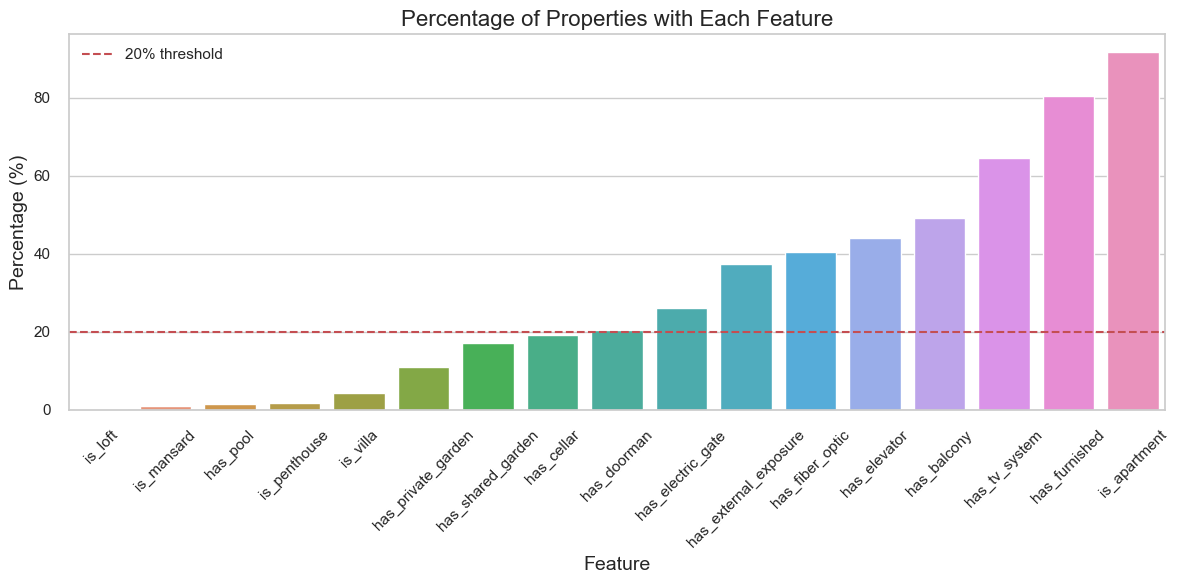

In [7]:
# Check the distribution of binary features
binary_features = [col for col in df.columns if col.startswith('has_') or col.startswith('is_')]

# Calculate the percentage of 1's in each binary feature
binary_distribution = pd.DataFrame({
    'Feature': binary_features,
    'Percentage_of_1s': [df[col].mean() * 100 for col in binary_features]
}).sort_values('Percentage_of_1s')

# Visualize the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Percentage_of_1s', data=binary_distribution)
plt.title('Percentage of Properties with Each Feature', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.axhline(y=20, color='r', linestyle='--', label='20% threshold')
plt.legend()
plt.tight_layout()
plt.show()

- Features like `is_loft`, `is_mansard`, `has_pool`, `is_penthouse`, `is_villa`, `has_private_garden`, `has_shared_garden`, and `has_cellar` are very rare (below 20% threshold)
- On the other end, `is_apartment` is extremely common (nearly 90% of properties)
- Features like `has_doorman`, `has_electric_gate`, `has_external_exposure`, `has_fiber_optic`, `has_elevator`, `has_balcony`, `has_tv_system`, and `has_furnished` are above the 20% threshold

Instead of using the rare binary features, we are going to group them inside a new `luxury_score` feature combining rare amenities.

In [8]:
# Identify highly skewed features (less than 5% or more than 95%)
highly_skewed = binary_distribution[
    (binary_distribution['Percentage_of_1s'] < 20) | 
    (binary_distribution['Percentage_of_1s'] > 80)
]['Feature'].tolist()

print(f"Highly skewed binary features: {highly_skewed}")

# Create a composite luxury feature from rare amenities
rare_amenities = [feature for feature in highly_skewed if feature in df.columns and df[feature].mean() < 0.05]
print(f"Rare amenities to combine: {rare_amenities}")

if rare_amenities:
    df['luxury_score'] = df[rare_amenities].sum(axis=1)
    print("Created 'luxury_score' feature combining rare amenities")
    
    # Check distribution of the new feature
    print("\nLuxury score distribution:")
    print(df['luxury_score'].value_counts().sort_index())

Highly skewed binary features: ['is_loft', 'is_mansard', 'has_pool', 'is_penthouse', 'is_villa', 'has_private_garden', 'has_shared_garden', 'has_cellar', 'has_furnished', 'is_apartment']
Rare amenities to combine: ['is_loft', 'is_mansard', 'has_pool', 'is_penthouse', 'is_villa']
Created 'luxury_score' feature combining rare amenities

Luxury score distribution:
luxury_score
0    98148
1     8449
2      536
Name: count, dtype: int64


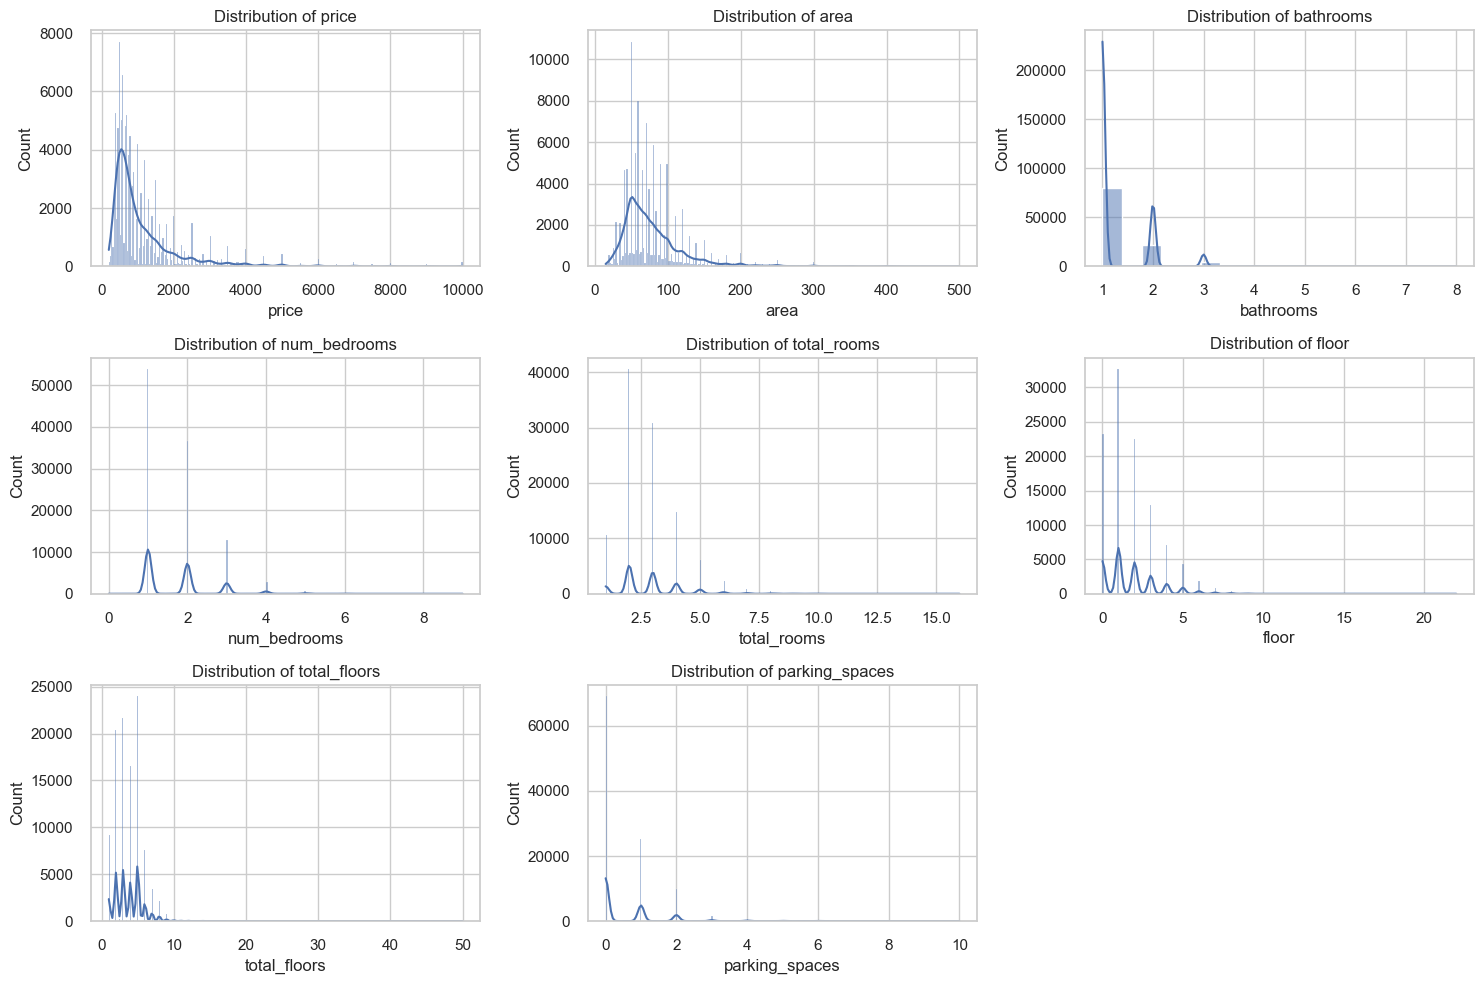

In [9]:
# Check distribution of numeric features
numeric_features = [
    'price', 'area', 'bathrooms', 'num_bedrooms', 'total_rooms', 
    'floor', 'total_floors', 'parking_spaces'
]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

Looking at the distribution plots for your numeric features, we can see several patterns:

1. `price` is right-skewed with most rentals between €500-2000, but with a long tail extending to €10000.
2. `area` shows a right-skewed distribution with most properties between 50-150 m², but with a long tail extending to 300+ m².
3. `bathrooms` is discrete with most properties having 1 or 2 bathrooms.
4. `num_bedrooms` is discrete with peaks at 1, 2, and 3 bedrooms.
5. `total_rooms` shows discrete peaks at 2, 3, 4, and 5 rooms.
6. `floor` has peaks at ground floor (0) and floors 1-4.
7. `total_floors` is concentrated between 1-10 floors.
8. `parking_spaces` is heavily concentrated at 0 and 1.

Based on these distributions, we will be applying log transformation to both `price` (target variable) and `area` since they show significant right skew. This will help normalize these distributions and improve model performance.

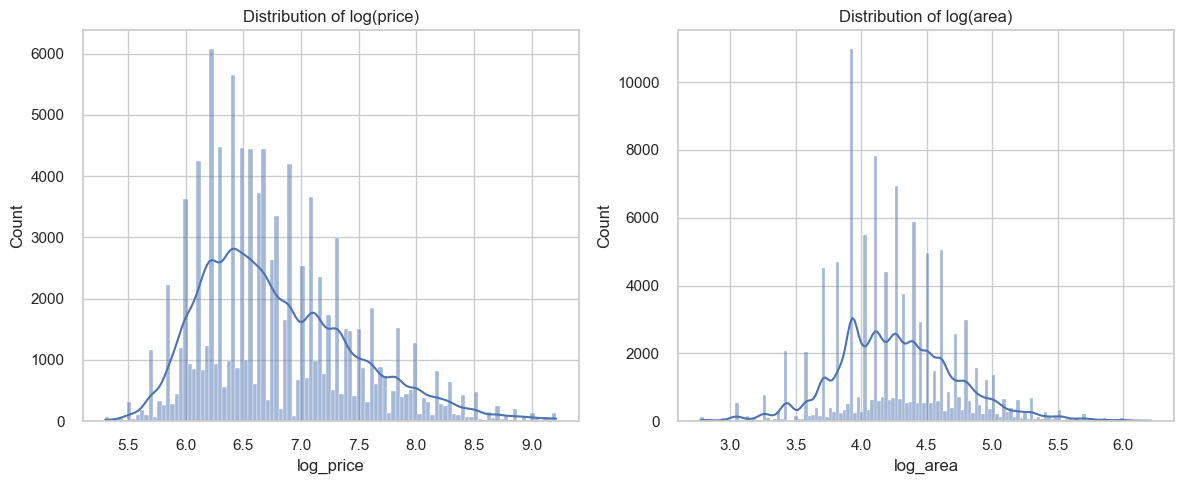

In [13]:
# Apply log transformation to price and area
df['log_price'] = np.log1p(df['price'])
df['log_area'] = np.log1p(df['area'])

# Visualize the log-transformed distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['log_price'], kde=True)
plt.title('Distribution of log(price)')

plt.subplot(1, 2, 2)
sns.histplot(df['log_area'], kde=True)
plt.title('Distribution of log(area)')
plt.tight_layout()
plt.show()

The log transformations have successfully normalized both distributions:

- **log(price)**: Now follows a more normal distribution. It's still slightly right-skewed but much closer to normal, with most values between 6.0-7.5 (approximately €400-€1800).
- **log(area)**: also shows improvement, with a more bell-shaped distribution centered around 4.0-4.5 (approximately 55-90 m²). There are some interesting peaks in the distribution that likely correspond to standard apartment sizes in the Italian market.

These transformations will help our model better handle the relationship between variables, especially for higher-priced properties and larger apartments.

### 5.2. Machine Learning Pipeline

In [14]:
# Define our features and target variable
X_features = [
    'log_area', 'bathrooms', 'num_bedrooms', 
    'floor_to_height_ratio', 'total_floors', 'parking_spaces',
    'has_elevator', 'has_doorman', 'has_balcony', 
    'has_external_exposure', 'has_furnished',
    'region_standardized', 'city', 'luxury_score'
]

# Remove the individual rare amenities from the feature list
X_features = [f for f in X_features if f not in rare_amenities]

# Define X and y (using log_price as target)
X = df[X_features].copy()
y = df['log_price']

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Identify numeric and categorical features
numeric_features = [
    'log_area', 'bathrooms', 'floor_to_height_ratio', 
    'total_floors', 'parking_spaces', 'luxury_score'
]

binary_features = [col for col in X.columns if col.startswith('has_') or col.startswith('is_')]
categorical_features = ['region_standardized', 'city']

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', 'passthrough', binary_features), 
        ('cat', categorical_transformer, categorical_features)
    ]
)

Training set size: 85706 samples
Testing set size: 21427 samples


### 5.2. Model Selection Process

In [11]:
# Let's evaluate multiple regression models to find the best performer

# Create a dictionary to store model results
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=7),
    'Lasso Regression': Lasso(random_state=7),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=7),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=7),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=7),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=7)
}

# Create a dictionary to store results
results = {}

# Train and evaluate each model
print("Evaluating baseline models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline with preprocessor and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': pipeline,
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

Evaluating baseline models...

Training Linear Regression...
Linear Regression - RMSE: 0.3609, MAE: 0.2643, R²: 0.7016

Training Ridge Regression...
Ridge Regression - RMSE: 0.3596, MAE: 0.2639, R²: 0.7037

Training Lasso Regression...
Lasso Regression - RMSE: 0.6607, MAE: 0.5312, R²: -0.0000

Training Random Forest...
Random Forest - RMSE: 0.3463, MAE: 0.2319, R²: 0.7253

Training Gradient Boosting...
Gradient Boosting - RMSE: 0.4023, MAE: 0.2988, R²: 0.6291

Training XGBoost...
XGBoost - RMSE: 0.3558, MAE: 0.2587, R²: 0.7100

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 85706, number of used features: 456
[LightGBM] [Info] Start training from score 6.793537
LightGBM - RMSE: 0.3599, MAE: 0.2619, 


Model Performance Comparison:


,Model,RMSE,MAE,R²
3,Random Forest,0.346289,0.231896,0.725268
5,XGBoost,0.355781,0.258717,0.710000
1,Ridge Regression,0.359638,0.263918,0.703678
6,LightGBM,0.359868,0.261874,0.703298
0,Linear Regression,0.360900,0.264316,0.701595
4,Gradient Boosting,0.402344,0.298829,0.629124
2,Lasso Regression,0.660672,0.531209,-0.000010


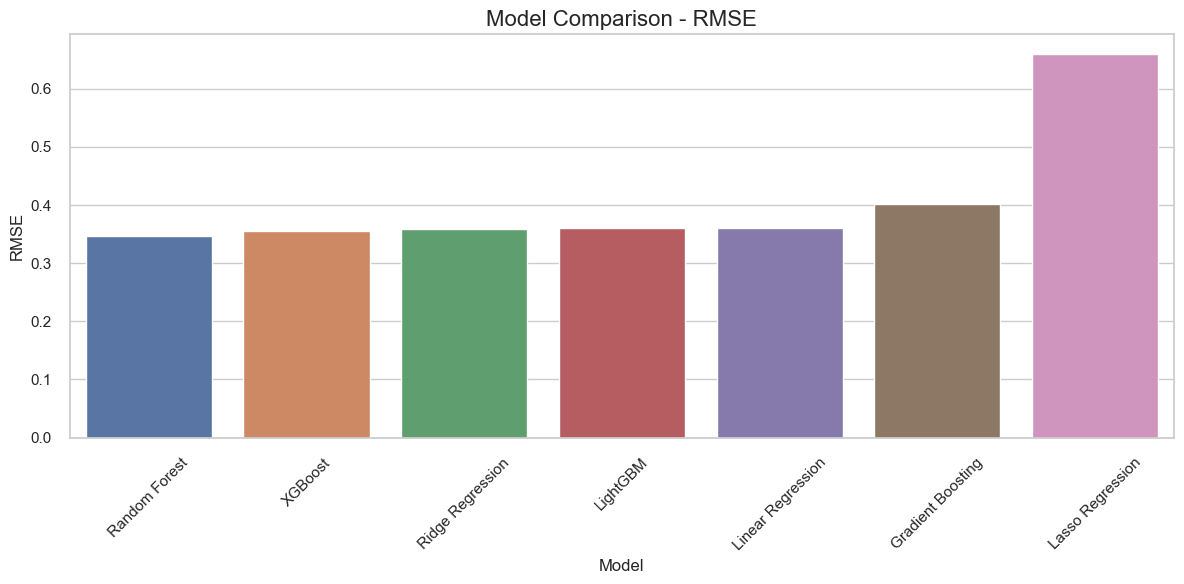

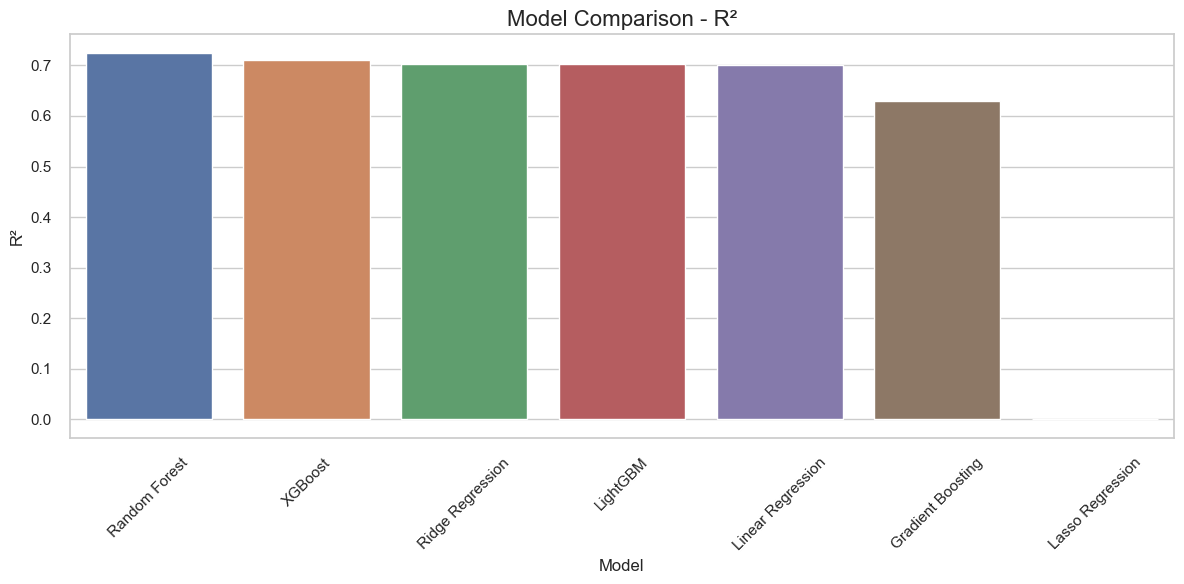


Best performing model: Random Forest


In [13]:
# Create a DataFrame to compare model performance
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[model]['rmse'] for model in results],
    'MAE': [results[model]['mae'] for model in results],
    'R²': [results[model]['r2'] for model in results]
}).sort_values('RMSE')

print("\nModel Performance Comparison:")
display(performance_df)

# Visualize model performance
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=performance_df)
plt.title('Model Comparison - RMSE', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R²', data=performance_df)
plt.title('Model Comparison - R²', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify the best model
best_model_name = performance_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")

Looking at the model comparison, Random Forest outperforms the other algorithms with the lowest RMSE (0.346) and highest R² (0.725). XGBoost comes in as a close second with slightly higher RMSE (0.356) and R² of 0.71.

The linear models (Ridge, Linear Regression) continue to perform surprisingly well, with Ridge Regression achieving an R² of 0.704, suggesting that many relationships in the Italian rental market follow somewhat linear patterns. LightGBM performs similarly to the linear models with an R² of 0.703.

Gradient Boosting shows moderate performance with an R² of 0.629, while Lasso Regression performs extremely poorly with an R² of essentially zero, confirming that its aggressive feature selection eliminates too many relevant variables for this complex market.

While the Random Forest model achieved slightly better performance metrics (lower RMSE and higher R²), the extensive grid search is proving prohibitively time-consuming on our hardware. XGBoost offers a compelling alternative with nearly comparable predictive power but significantly faster training times. This efficiency comes from XGBoost's optimized implementation and gradient-based approach to building trees sequentially rather than independently. For our Italian rental price prediction task, the marginal performance difference (approximately 0.015 in R²) is an acceptable trade-off for the substantial reduction in training time, allowing us to iterate more quickly and potentially explore a wider range of hyperparameters.

**Reminder: the RMSE and MAE are not relative to the actual price, but to the normalized price after applying the log transformation. We will deal with this later after the final training of our best model.**

### 5.3. Model Training

In [16]:
# Create a dedicated validation set for early stopping
X_train_main, X_eval, y_train_main, y_eval = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
# First, preprocess all data
preprocessor.fit(X_train)
X_train_main_processed = preprocessor.transform(X_train_main)
X_eval_processed = preprocessor.transform(X_eval)

xgb_param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoost model 
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,  # Early stopping will determine actual count
    early_stopping_rounds=10,
    eval_metric='rmse',
    random_state=7
)

# Perform grid search with cross-validation
xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the preprocessed data
xgb_grid_search.fit(
    X_train_main_processed, y_train_main,
    eval_set=[(X_eval_processed, y_eval)]
)

# Print the best parameters and score
print("Best parameters:", xgb_grid_search.best_params_)
print("Best RMSE:", -xgb_grid_search.best_score_)

# Get the best model
best_xgb_model = xgb_grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[0]	validation_0-rmse:0.62818
[1]	validation_0-rmse:0.59568
[2]	validation_0-rmse:0.56783
[3]	validation_0-rmse:0.54371
[4]	validation_0-rmse:0.52250
[5]	validation_0-rmse:0.50455
[6]	validation_0-rmse:0.48881
[7]	validation_0-rmse:0.47805
[8]	validation_0-rmse:0.46566
[9]	validation_0-rmse:0.45538
[10]	validation_0-rmse:0.44715
[11]	validation_0-rmse:0.43919
[12]	validation_0-rmse:0.43176
[13]	validation_0-rmse:0.42574
[14]	validation_0-rmse:0.42006
[15]	validation_0-rmse:0.41537
[16]	validation_0-rmse:0.41142
[17]	validation_0-rmse:0.40833
[18]	validation_0-rmse:0.40511
[19]	validation_0-rmse:0.40230
[20]	validation_0-rmse:0.39950
[21]	validation_0-rmse:0.39658
[22]	validation_0-rmse:0.39402
[23]	validation_0-rmse:0.39245
[24]	validation_0-rmse:0.39082
[25]	validation_0-rmse:0.38944
[26]	validation_0-rmse:0.38808
[27]	validation_0-rmse:0.38643
[28]	validation_0-rmse:0.38504
[29]	validation_0-rmse:0.38389
[30]	validation_0-

In [17]:
# Get the best model
best_xgb_model = xgb_grid_search.best_estimator_

# Save the best model to disk
import pickle

# Save the model
with open('d:/Data_Science/Projects/House_Prices/models/best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

# Save the preprocessor as well
with open('d:/Data_Science/Projects/House_Prices/models/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

print("Model and preprocessor saved successfully!")

Model and preprocessor saved successfully!


In [16]:
# Load the model
with open('d:/Data_Science/Projects/House_Prices/models/best_xgb_model.pkl', 'rb') as f:
    best_xgb_model = pickle.load(f)

# Load the preprocessor
with open('d:/Data_Science/Projects/House_Prices/models/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

print("Model and preprocessor loaded successfully!")

# Verify the model is loaded correctly
print(f"Model type: {type(best_xgb_model).__name__}")
print(f"Model parameters: {best_xgb_model.get_params()}")

Model and preprocessor loaded successfully!
Model type: XGBRegressor
Model parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': 10, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 7, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': No

### 5.4. Model Evaluation

In [17]:
# Preprocess the test data
X_test_processed = preprocessor.transform(X_test)

# Evaluate the best model on the test set
y_pred = best_xgb_model.predict(X_test_processed)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nTest set performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Transform predictions back to original scale
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

# Calculate metrics on original scale
mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print(f"\nMetrics on original price scale (€):")
print(f"MAE: €{mae_original:.2f}")
print(f"RMSE: €{rmse_original:.2f}")


Test set performance:
RMSE: 0.3365
MAE: 0.2407
R²: 0.7406

Metrics on original price scale (€):
MAE: €303.62
RMSE: €606.04


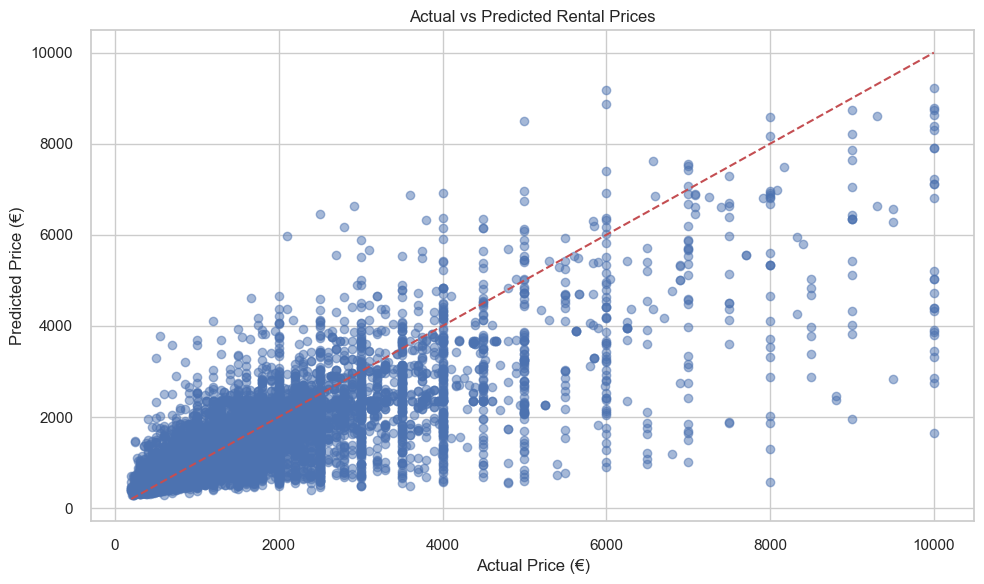

In [18]:
# actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--')
plt.xlabel('Actual Price (€)')
plt.ylabel('Predicted Price (€)')
plt.title('Actual vs Predicted Rental Prices')
plt.tight_layout()
plt.show()

Looking at the scatter plot of actual vs predicted rental prices, we can see that my model is performing reasonably well, especially for properties in the lower price range (below €4000).

The model shows a clear positive correlation between actual and predicted values, which is good. The red dashed line represents perfect predictions, and many data points cluster around this line.

However, we notice a few important patterns:

1. The model tends to underestimate prices for higher-value properties (above €6000)
2. There's more variance in predictions as the actual price increases
3. Most of the data is concentrated in the lower price range (€500-€3000)

This suggests that the model is better calibrated for typical rental properties but struggles with luxury or premium rentals. This makes sense given the distribution of the training data.

The test metrics (RMSE: €606.04, MAE: €303.62, R²: 0.74) confirm that the model has good predictive power overall, but there's still room for improvement, especially for high-end properties.

For future iterations, we should consider:
- Collecting more data for high-end properties
- Creating separate models for different price segments
- Adding more features that might better explain premium property pricing

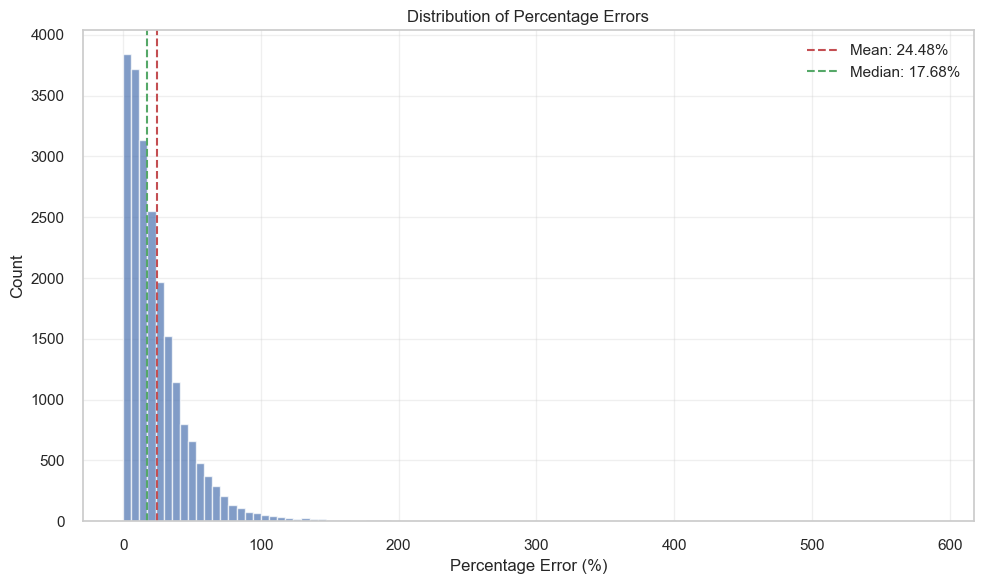

In [20]:
percent_errors = 100 * np.abs(y_pred_original - y_test_original) / y_test_original

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(percent_errors, bins=100, alpha=0.7)
plt.axvline(percent_errors.mean(), color='r', linestyle='--', 
            label=f'Mean: {percent_errors.mean():.2f}%')
plt.axvline(np.median(percent_errors), color='g', linestyle='--', 
            label=f'Median: {np.median(percent_errors):.2f}%')
plt.xlabel('Percentage Error (%)')
plt.ylabel('Count')
plt.title('Distribution of Percentage Errors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### My Thoughts on Error Distribution

Looking at this histogram, I'm pretty happy with how the model is performing! Most of the predictions are within 20% of the actual rental prices, which is good enough for a practical estimate.

The median error is 17.68% - meaning half of my predictions are closer than this to the real price. The mean is a bit higher (24.48%) because of some expensive rentals pulling it up.

I notice most errors cluster in the 10-20% range, which feels reasonable for real estate predictions. After all, even human experts can't perfectly price rentals!

The errors above 100% are probably unusual properties and the model hasn't seen enough examples of. I could improve this by collecting more data on these edge cases or tweaking how I handle outliers.

### 5.4. Reiterating: feature engineering, cleaning, and transformations

In [21]:
feature_importance = best_xgb_model.feature_importances_

# Create a dictionary to store feature importance
feature_importance_dict = {}

# Print the top 15 features by importance
print("Top 15 features by importance:")
indices = np.argsort(feature_importance)[::-1][:15]
for i, idx in enumerate(indices):
    # Try to get a meaningful name for the feature
    if idx < len(X_features):
        feature_name = X_features[idx]
    else:
        feature_name = f"feature_{idx}"
    
    # Store in dictionary
    feature_importance_dict[feature_name] = feature_importance[idx]

Top 15 features by importance:


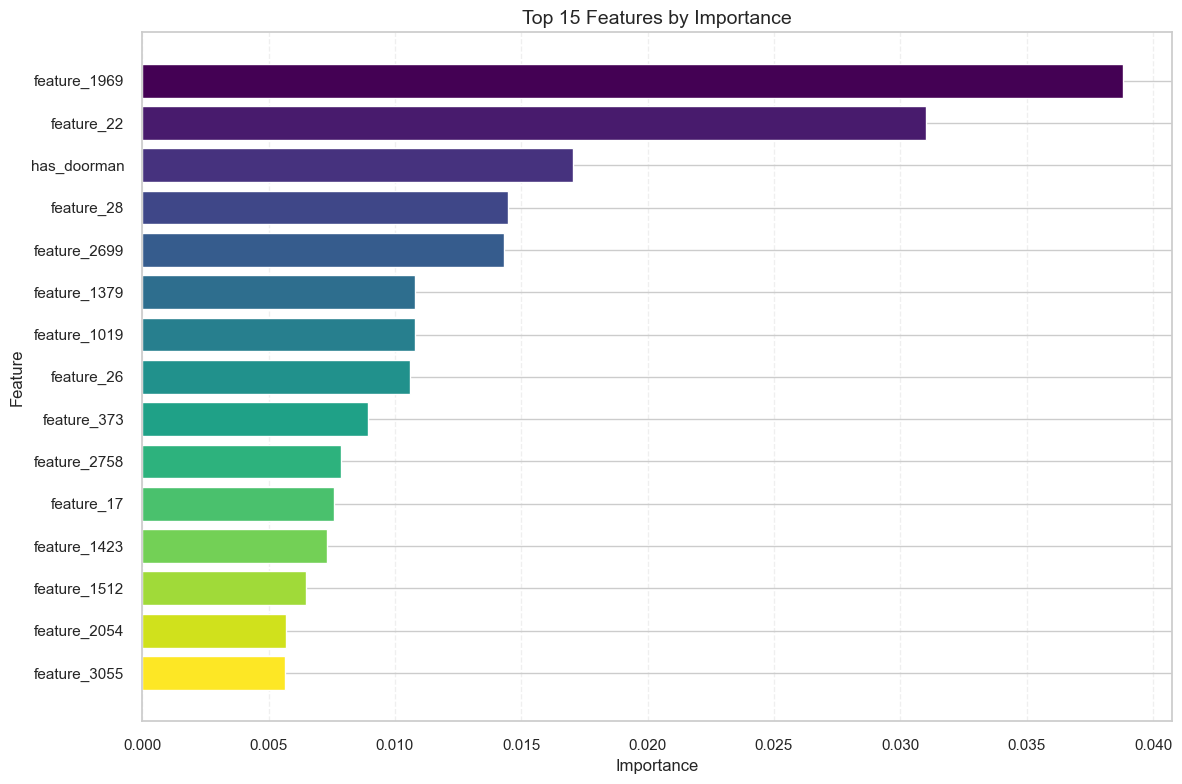

In [22]:
# Visualize the top 15 features
plt.figure(figsize=(12, 8))
top_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:15]
features = [x[0] for x in top_features]
importances = [x[1] for x in top_features]

# Create a colorful plot
colors = plt.cm.viridis(np.linspace(0, 1, len(features)))
plt.barh(features, importances, color=colors)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Features by Importance', fontsize=14)
plt.gca().invert_yaxis()  # Display highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

features with numbers are not really interpretable, the only significant one based on the grapgh above is `has_doorman`. 

In [24]:
# Get feature names directly from preprocessor
original_feature_names = preprocessor.get_feature_names_out(X_features)

# Map feature indices to names
feature_name_mapping = {
    f"feature_{i}": name 
    for i, name in enumerate(original_feature_names)
}

# Update feature importance with actual names
named_importance = {}
for feature, importance in feature_importance_dict.items():
    if feature.startswith('feature_'):
        actual_name = feature_name_mapping.get(feature, feature)
        named_importance[actual_name] = importance
    else:
        named_importance[feature] = importance

# Print results
print(f"Found {len(original_feature_names)} feature names")
print(f"First 10 feature names: {original_feature_names[:10]}")

print("\nTop 10 features with actual names:")
for i, (feature, importance) in enumerate(
    sorted(
        named_importance.items(),
        key=lambda x: x[1],
        reverse=True
    )[:15]
):
    print(f"{i+1}. {feature}: {importance:.6f}")


Found 3759 feature names
First 10 feature names: ['num__log_area' 'num__bathrooms' 'num__floor_to_height_ratio'
 'num__total_floors' 'num__parking_spaces' 'num__luxury_score'
 'bin__has_elevator' 'bin__has_doorman' 'bin__has_balcony'
 'bin__has_external_exposure']

Top 10 features with actual names:
1. cat__city_Milano: 0.038805
2. cat__region_standardized_Piemonte: 0.031000
3. has_doorman: 0.017053
4. cat__region_standardized_Umbria: 0.014467
5. cat__city_Riccione: 0.014314
6. cat__city_Firenze: 0.010798
7. cat__city_Cervia: 0.010778
8. cat__region_standardized_Toscana: 0.010589
9. cat__city_Bologna: 0.008952
10. cat__city_Roma: 0.007865
11. cat__region_standardized_Lazio: 0.007579
12. cat__city_Forte dei Marmi: 0.007314
13. cat__city_Genova: 0.006464
14. cat__city_Monte Argentario: 0.005703
15. cat__city_Santa Margherita Ligure: 0.005637


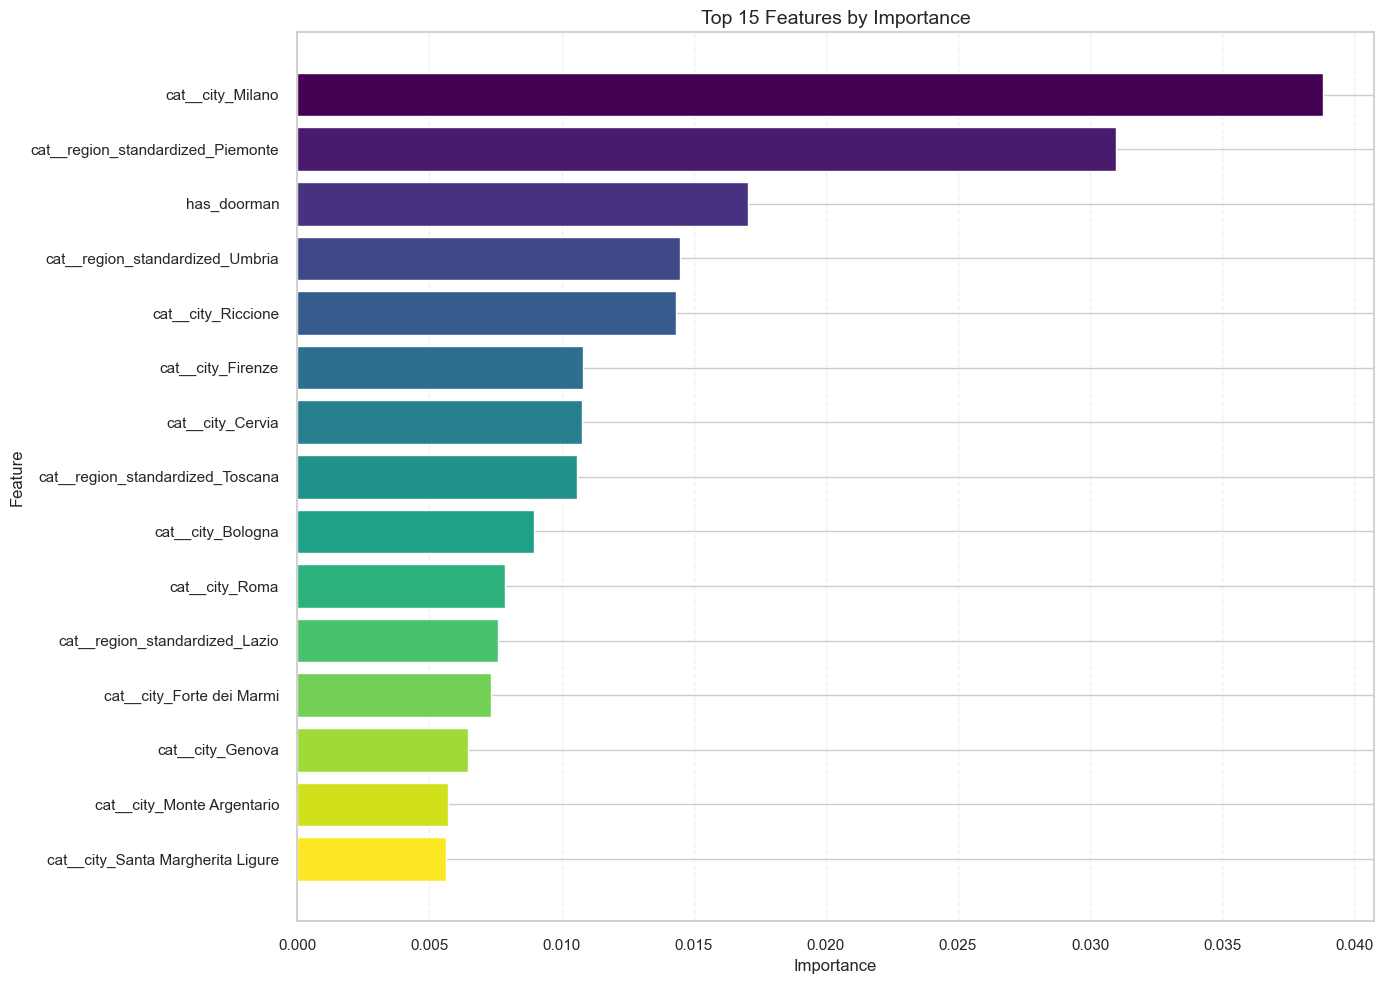

In [25]:
# Visualize the top 15 features with their actual names
plt.figure(figsize=(14, 10))
top_features = sorted(named_importance.items(), key=lambda x: x[1], reverse=True)[:15]
features = [x[0] for x in top_features]
importances = [x[1] for x in top_features]

# Create a colorful plot
colors = plt.cm.viridis(np.linspace(0, 1, len(features)))
plt.barh(features, importances, color=colors)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Features by Importance', fontsize=14)
plt.gca().invert_yaxis()  # Display highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Create a markdown cell to analyze these results

Interestingly, physical property characteristics (area, bathrooms, bedrooms) don't appear in the top 15 features, suggesting that the model finds where a property is located more importan than its physical attributes.

The only thing we can do now is drop those exrem outliers and see if the model improves. We will put a cap on the price at 3000 euro.

In [28]:
# Cap extreme price values at 3000 euros
df_capped = df.copy()
df_capped['price'] = df_capped['price'].clip(upper=3000)

# Check the effect of capping
print(f"Original price range: {df['price'].min()} to {df['price'].max()}")
print(f"Capped price range: {df_capped['price'].min()} to {df_capped['price'].max()}")
print(f"Number of prices capped: {(df['price'] > 3000).sum()}")
print(f"Percentage of prices capped: {(df['price'] > 3000).sum() / len(df) * 100:.2f}%")

Original price range: 200.0 to 10000.0
Capped price range: 200.0 to 3000.0
Number of prices capped: 5545
Percentage of prices capped: 5.18%


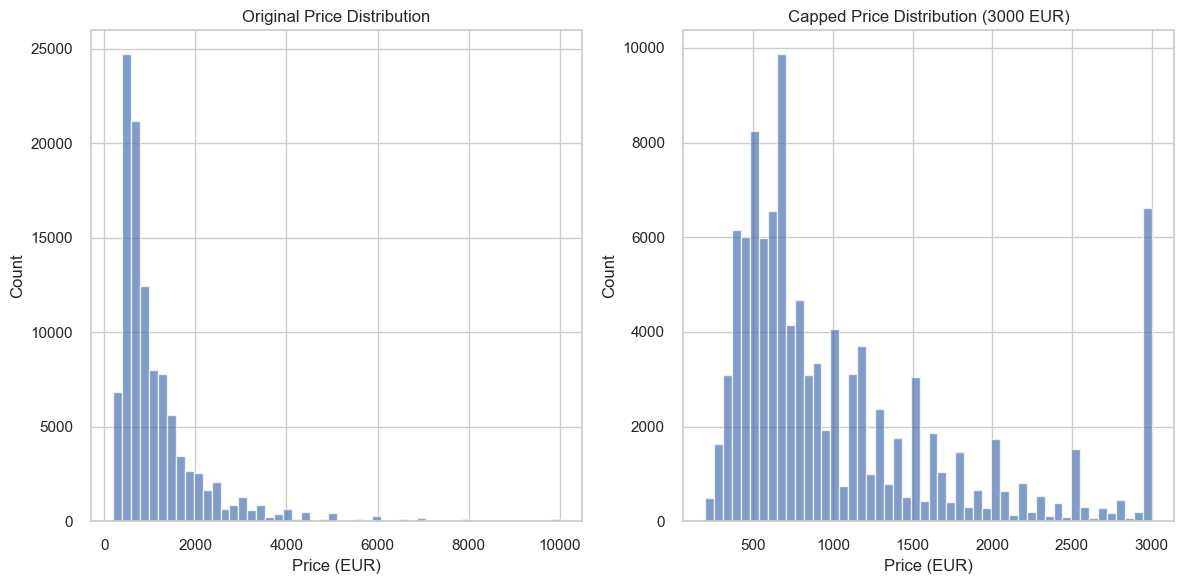

In [29]:
# Plot the distribution of prices before and after capping
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=50, alpha=0.7)
plt.title('Original Price Distribution')
plt.xlabel('Price (EUR)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df_capped['price'], bins=50, alpha=0.7)
plt.title('Capped Price Distribution (3000 EUR)')
plt.xlabel('Price (EUR)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [31]:
# Prepare the data with prices capped at 3000 EUR
X_capped = df_capped[X_features]
y_capped = np.log1p(df_capped['price']) 

# Split the data
X_train_capped, X_test_capped, y_train_capped, y_test_capped = train_test_split(
    X_capped, y_capped, test_size=0.2, random_state=7
)

# Check the shapes
print(f"Training features shape: {X_train_capped.shape}")
print(f"Training target shape: {y_train_capped.shape}")
print(f"Testing features shape: {X_test_capped.shape}")
print(f"Testing target shape: {y_test_capped.shape}")


Training features shape: (85706, 14)
Training target shape: (85706,)
Testing features shape: (21427, 14)
Testing target shape: (21427,)


In [35]:
# Preprocess the capped data using the existing preprocessor
X_train_capped_processed = preprocessor.transform(X_train_capped)
X_test_capped_processed = preprocessor.transform(X_test_capped)

# Get parameters from best model but remove early stopping related ones
best_params = best_xgb_model.get_params()
if 'early_stopping_rounds' in best_params:
    del best_params['early_stopping_rounds']
if 'eval_metric' in best_params:
    del best_params['eval_metric']

# Create a new XGBoost model with the modified parameters
capped_xgb_model = XGBRegressor(**best_params)

# Train the model
capped_xgb_model.fit(X_train_capped_processed, y_train_capped)

# Make predictions
y_pred_capped = capped_xgb_model.predict(X_test_capped_processed)

# Convert predictions back to original scale
y_pred_capped_orig = np.expm1(y_pred_capped)
y_test_capped_orig = np.expm1(y_test_capped)


Model performance with prices capped at 3000 EUR:
RMSE: 391.8724
MAE: 239.0982
R²: 0.7112
Median percentage error: 16.36%
Mean percentage error: 22.66%


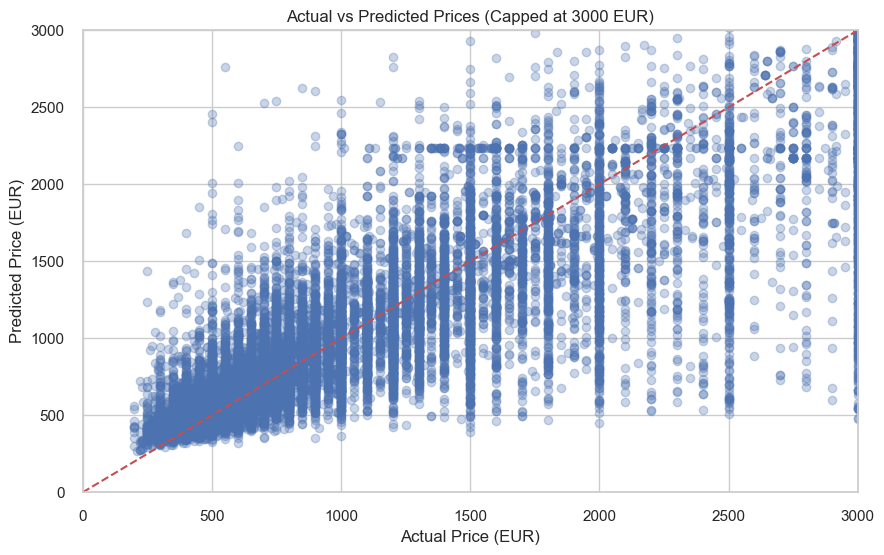

In [36]:
# Calculate metrics
mse_capped = mean_squared_error(y_test_capped_orig, y_pred_capped_orig)
rmse_capped = np.sqrt(mse_capped)
mae_capped = mean_absolute_error(y_test_capped_orig, y_pred_capped_orig)
r2_capped = r2_score(y_test_capped_orig, y_pred_capped_orig)

# Calculate percentage errors
percentage_errors_capped = np.abs(y_pred_capped_orig - y_test_capped_orig) / y_test_capped_orig * 100

# Print metrics
print("\nModel performance with prices capped at 3000 EUR:")
print(f"RMSE: {rmse_capped:.4f}")
print(f"MAE: {mae_capped:.4f}")
print(f"R²: {r2_capped:.4f}")
print(f"Median percentage error: {np.median(percentage_errors_capped):.2f}%")
print(f"Mean percentage error: {np.mean(percentage_errors_capped):.2f}%")

# Visualize actual vs predicted prices
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test_capped_orig, y_pred_capped_orig, alpha=0.3)
plt.plot([0, 3000], [0, 3000], 'r--')
plt.xlabel('Actual Price (EUR)')
plt.ylabel('Predicted Price (EUR)')
plt.title('Actual vs Predicted Prices (Capped at 3000 EUR)')
plt.xlim(0, 3000)
plt.ylim(0, 3000)
plt.grid(True)
plt.show()

### 5.5 Model Selection: Original vs. Capped
We selected the original model (without price capping) because:

We selected the original model (without price capping) because it demonstrates superior performance metrics with a higher R² (0.7406 vs 0.7112) and lower RMSE (303.62 vs 391.87). The uncapped approach provides full price range coverage, handling both standard and premium properties while preserving important market dynamics that influence luxury property pricing. Plus, The model delivers more accurate predictions across the entire Italian rental market spectrum, offering practical utility for users interested in all property segments.


In [37]:
# Calculate and save confidence metrics for the Streamlit app
import os
import pickle

# Calculate median percentage error for confidence display
percentage_errors = np.abs(y_pred_original - y_test_original) / y_test_original * 100
median_percentage_error = np.median(percentage_errors)
confidence_percentage = max(0, 100 - median_percentage_error)  # Convert error to confidence

# Save just the confidence metrics
confidence_metrics = {
    'confidence_percentage': confidence_percentage,
    'median_percentage_error': median_percentage_error
}

# Save the confidence metrics
with open('d:/Data_Science/Projects/House_Prices/models/confidence_metrics.pkl', 'wb') as f:
    pickle.dump(confidence_metrics, f)

print("Confidence metrics saved successfully!")
print(f"Model confidence: {confidence_percentage:.2f}%")

Confidence metrics saved successfully!
Model confidence: 82.32%
